In [1]:
from math import factorial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit
import numpy as np
from functools import partial

In [2]:
def number_nonredundant_amplitudes(nmo, nocc, exci):
    nvirt = nmo - nocc
    ret = 1
    for e in range(exci):
        ret *= (nocc - e) * (nvirt - e)
    ret //= (factorial(exci)) ** 2
    return ret


def number_overlaps_tccsd(nmo, nalpha, nbeta):
    nvirta = nmo - nalpha
    nvirtb = nmo - nbeta
    singles = number_nonredundant_amplitudes(nmo, nalpha, 1) + number_nonredundant_amplitudes(
        nmo, nbeta, 1
    )
    doubles = number_nonredundant_amplitudes(nmo, nalpha, 2) + number_nonredundant_amplitudes(
        nmo, nbeta, 2
    )
    ret = 1 + singles + doubles + (nalpha * nbeta * nvirta * nvirtb)
    return ret

In [3]:
data = pd.read_hdf("noise_data_general_9mol.h5", key="df")

data_stretched = pd.read_hdf("noise_data_general_stretched.h5", key="df")
data = pd.concat([data, data_stretched], ignore_index=True)

print("Before NaN filter:", len(data.index))
data = data[data['df'].notna()]
print("After NaN filter:", len(data.index))

data['ncas'] = data.nact
data['nvirta'] = data.nact - data.nalpha
data['nvirtb'] = data.nact - data.nbeta
data['noverlaps'] = number_overlaps_tccsd(data.nact, data.nalpha, data.nbeta)

Before NaN filter: 845
After NaN filter: 653


In [6]:
merged_df = pd.DataFrame()
payload = list(data.columns)
payload = [p for p in payload if p not in ['pytest_obj', 'test_id', 'status', 'duration_ms', 'df']]
for _, row in data.iterrows():
    inner_df = row['df']
    for p in payload:
        inner_df[p] = row[p]
    merged_df = pd.concat([merged_df, inner_df])
merged_df.reset_index(drop=True, inplace=True)

# merged_df = merged_df[merged_df['nact'] >= 4]
merged_df = merged_df[merged_df['noverlaps'] > 100]
# merged_df = merged_df[~merged_df.basis.str.contains('cc-pvdz')]

print(merged_df.shape)
print(merged_df.columns)
display(merged_df)
merged_df_backup = merged_df.copy()
merged_df.to_hdf("error_model_noise_tccsd.h5", key="df")

(19590, 17)
Index(['std', 'e_tot', 'e_exact', 'tcc_error', 'basis', 'molname', 'nact',
       'nalpha', 'nbeta', 'nelec', 'nao', 'nmo', 'noverlaps_exp', 'ncas',
       'nvirta', 'nvirtb', 'noverlaps'],
      dtype='object')


,std,e_tot,e_exact,tcc_error,basis,molname,nact,nalpha,nbeta,nelec,nao,nmo,noverlaps_exp,ncas,nvirta,nvirtb,noverlaps
0,0.001,-107.650188,-107.650214,0.000026,sto-3g,n2,6,3,3,14.0,10.0,20.0,118.0,6,3,3,118
1,0.001,-107.650717,-107.650214,0.000503,sto-3g,n2,6,3,3,14.0,10.0,20.0,118.0,6,3,3,118
2,0.001,-107.650713,-107.650214,0.000500,sto-3g,n2,6,3,3,14.0,10.0,20.0,118.0,6,3,3,118
3,0.001,-107.650807,-107.650214,0.000593,sto-3g,n2,6,3,3,14.0,10.0,20.0,118.0,6,3,3,118
4,0.001,-107.650805,-107.650214,0.000592,sto-3g,n2,6,3,3,14.0,10.0,20.0,118.0,6,3,3,118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19585,0.001,-230.226590,-230.226633,0.000043,aug-cc-pvdz,p-benzyne,16,8,8,40.0,174.0,348.0,5793.0,16,8,8,5793
19586,0.001,-230.226520,-230.226633,0.000114,aug-cc-pvdz,p-benzyne,16,8,8,40.0,174.0,348.0,5793.0,16,8,8,5793
19587,0.001,-230.226519,-230.226633,0.000114,aug-cc-pvdz,p-benzyne,16,8,8,40.0,174.0,348.0,5793.0,16,8,8,5793
19588,0.001,-230.226771,-230.226633,0.000137,aug-cc-pvdz,p-benzyne,16,8,8,40.0,174.0,348.0,5793.0,16,8,8,5793


In [4]:
new_df = merged_df_backup.set_index(['molname', 'basis'])
new_df = new_df[["nmo"]]
new_df.drop_duplicates(inplace=True)
# new_df.shape
new_df

nmo
molname      basis             
n2           sto-3g        20.0
             6-31g         36.0
             6-31g**       56.0
             aug-cc-pvdz   92.0
h2o          6-31g         26.0
             6-31g**       48.0
             aug-cc-pvdz   82.0
nco          sto-3g        46.0
             6-31g         84.0
             6-31g**      142.0
             aug-cc-pvdz  238.0
formaldehyde sto-3g        24.0
             6-31g         44.0
             6-31g**       76.0
             aug-cc-pvdz  128.0
acetaldehyde sto-3g        38.0
             6-31g         70.0
             6-31g**      124.0
             aug-cc-pvdz  210.0
benzene      sto-3g        72.0
             6-31g        132.0
             6-31g**      228.0
             aug-cc-pvdz  384.0
cl2          6-31g         52.0
             aug-cc-pvdz  108.0
furan        sto-3g        58.0
             6-31g        106.0
             6-31g**      180.0
             aug-cc-pvdz  302.0
p-benzyne    sto-3g        68.0
             6-31g**      208.0
             aug-cc-pvdz  348.0

In [5]:
new_df = merged_df_backup.set_index(['ncas', 'nalpha', 'nbeta'])
new_df = new_df[["noverlaps"]]
new_df.drop_duplicates(inplace=True)
# new_df.unstack()
# new_df.shape
new_df
new_df.to_latex("cas_list.tex")

### Create a dataframe with <E_TCC>

In [6]:
columns_to_groupby = ['std', 'basis', 'molname', 'nact', 'nalpha', 'nbeta', 'nelec', 'nao', 'nmo', 'noverlaps']
df_mean = merged_df.groupby(columns_to_groupby)['tcc_error'].mean().reset_index()
display(df_mean)

merged_df = df_mean
df_mean.describe()

,std,basis,molname,nact,nalpha,nbeta,nelec,nao,nmo,noverlaps,tcc_error
0,0.001,6-31g,acetaldehyde,6,3,3,24.0,35.0,70.0,118,0.000078
1,0.001,6-31g,acetaldehyde,8,2,2,24.0,35.0,70.0,199,0.000093
2,0.001,6-31g,acetaldehyde,8,3,3,24.0,35.0,70.0,316,0.000084
3,0.001,6-31g,acetaldehyde,8,4,4,24.0,35.0,70.0,361,0.000096
4,0.001,6-31g,acetaldehyde,10,5,5,24.0,35.0,70.0,876,0.000153
...,...,...,...,...,...,...,...,...,...,...,...
648,0.001,sto-3g,p-benzyne,16,3,3,40.0,34.0,68.0,2068,0.000344
649,0.001,sto-3g,p-benzyne,16,4,4,40.0,34.0,68.0,3193,0.000478
650,0.001,sto-3g,p-benzyne,16,5,5,40.0,34.0,68.0,4236,0.000492
651,0.001,sto-3g,p-benzyne,16,6,6,40.0,34.0,68.0,5071,0.000422


,std,nact,nalpha,nbeta,nelec,nao,nmo,noverlaps,tcc_error
count,6.530000e+02,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,6.530000e+02
mean,1.000000e-03,11.623277,4.493109,4.493109,26.392037,57.122511,114.245023,1946.332312,3.748719e-04
std,2.170067e-19,3.701957,1.572003,1.572003,10.671017,40.701672,81.403343,1828.450983,5.348730e-04
min,1.000000e-03,6.000000,2.000000,2.000000,10.000000,10.000000,20.000000,118.000000,5.597747e-07
25%,1.000000e-03,8.000000,3.000000,3.000000,16.000000,28.000000,56.000000,316.000000,1.116944e-04
50%,1.000000e-03,10.000000,5.000000,5.000000,24.000000,42.000000,84.000000,876.000000,2.023763e-04
75%,1.000000e-03,16.000000,6.000000,6.000000,36.000000,71.000000,142.000000,3193.000000,3.659280e-04
max,1.000000e-03,16.000000,8.000000,8.000000,42.000000,192.000000,384.000000,5793.000000,3.013398e-03


In [7]:
import numpy as np
from scipy.optimize import curve_fit
X = merged_df[['noverlaps', 'nmo']].values
y = merged_df['tcc_error'].values
print(X.shape, y.shape)


def power_law(noverlaps, nmo, a, b, c):
    return a * np.power(noverlaps, b) * np.power(nmo, c)

def power_law_stacked(X, a, b, c):
    # noverlaps, nmo, nelec = X[:, 0], X[:, 1], X[:, 2]
    noverlaps, nmo = X[:, 0], X[:, 1]
    return a * np.power(noverlaps, b) * np.power(nmo, c) #* np.power(nelec, d)

def power_law_1d(X, a, b, c):
    # noverlaps, nmo, nelec = X[0], X[1], X[2]
    noverlaps, nmo = X[0], X[1]
    return a * np.power(noverlaps, b) * np.power(nmo, c) #* np.power(nelec, d)

# Perform the curve fitting
sigma_fixed = merged_df['std'].unique()[0]

popt, pcov = curve_fit(power_law_stacked, X, y / sigma_fixed)
stderr = np.sqrt(np.diagonal(pcov))
print("std errors from lst sq", stderr)

a_fit, b_fit, c_fit = popt
d_fit = 0

print(f"Fitted coefficients: a={a_fit}, b={b_fit}, c={c_fit}, d={d_fit}")

# merged_df['tcc_error_fit'] = merged_df.apply(lambda x: power_law_1d([x.noverlaps, x.nmo], a_fit * sigma_fixed, b_fit, c_fit), axis=1)

(653, 2) (653,)
std errors from lst sq [2.37000614 0.03817577 0.09949991]
Fitted coefficients: a=5.594350298422523, b=0.27739246516863286, c=-1.0736763259639763, d=0


In [8]:
from tqdm import tqdm
boots_iter = 50_000

def run_powerlaw_fit(df=None):
    X = df[['noverlaps', 'nmo']].values
    y = df['tcc_error'].values / sigma_fixed
    popt, _ = curve_fit(power_law_stacked, X, y)
    return popt

boots_data = []
np.random.seed(42)
for N in tqdm(range(boots_iter)):
    sample_idx = np.random.randint(low=0, high=df_mean.shape[0], size=df_mean.shape[0])
    df_resampled = df_mean.iloc[sample_idx]
    assert sample_idx.size > np.unique(sample_idx).size
    assert df_mean.shape == df_resampled.shape
    popt = run_powerlaw_fit(df_resampled)
    boots_data.append(popt)
df_boots = pd.DataFrame(data=boots_data, columns=["a", "b", "c"])
stderr = df_boots.std().values


100%|██████████| 50000/50000 [05:44<00:00, 145.01it/s]


In [9]:
display(df_boots.describe())
print(df_boots.std().values)

,a,b,c
count,50000.000000,50000.000000,50000.000000
mean,6.808309,0.278799,-1.085328
std,4.791349,0.054264,0.115986
min,0.964790,0.076987,-1.691688
25%,3.930871,0.241727,-1.156079
50%,5.524223,0.277276,-1.075658
75%,8.067869,0.314466,-1.003839
max,95.737673,0.534977,-0.756270


[4.79134852 0.05426389 0.11598562]


In [10]:
# keep the exponents b and c fixed and fit only the prefactor a per molecule
def power_law_mol_with_pref(X, a, b, c):
    noverlaps, nmo = X[:, 0], X[:, 1]
    return a * noverlaps**b * nmo**c

grouped = merged_df.groupby("molname")

power_law_only_pref = partial(power_law_mol_with_pref, b=b_fit, c=c_fit)
print(power_law_only_pref)
fit_data = []
for name, group in grouped:
    X = group[['noverlaps', 'nmo']].values
    y = group['tcc_error'].values / sigma_fixed
    popt, pcov = curve_fit(power_law_only_pref, X, y)
    sigmas = np.sqrt(np.diagonal(pcov))
    a_fit = popt[0]
    fit_data.append([name, a_fit, *sigmas])

df_per_mol_fits = pd.DataFrame(data=fit_data, columns=["molname", "a", "sigma_a"])
df_per_mol_fits.sort_values("a", inplace=True, ascending=False)
display(df_per_mol_fits)

prefactor_dict = {x.molname: x.a for _, x in df_per_mol_fits.iterrows()}
assert len(prefactor_dict) == df_per_mol_fits.shape[0]
merged_df['tcc_error_fit'] = merged_df.apply(lambda x: power_law_1d([x.noverlaps, x.nmo], sigma_fixed * prefactor_dict[x.molname], b_fit, c_fit), axis=1)

merged_df['tcc_error_fit_best'] = merged_df.apply(lambda x: power_law_1d([x.noverlaps, x.nmo],  sigma_fixed * prefactor_dict[x.molname], b_fit - stderr[1], c_fit - stderr[2]), axis=1)
merged_df['tcc_error_fit_worst'] = merged_df.apply(lambda x: power_law_1d([x.noverlaps, x.nmo], sigma_fixed * prefactor_dict[x.molname], b_fit + stderr[1], c_fit + stderr[2]), axis=1)

functools.partial(<function power_law_mol_with_pref at 0x7f98887f35e0>, b=0.27739246516863286, c=-1.0736763259639763)


,molname,a,sigma_a
10,n2_stretched,18.669051,0.997520
5,f2_stretched,6.476190,0.235102
12,p-benzyne,5.650327,0.231635
3,cl2_stretched,4.832977,0.299891
4,f2,4.270402,0.174156
9,n2,3.203512,0.155593
8,h2o,3.013966,0.225043
11,nco,3.001943,0.110190
1,benzene,2.979277,0.127405
6,formaldehyde,2.597973,0.121113


5.650326610963338


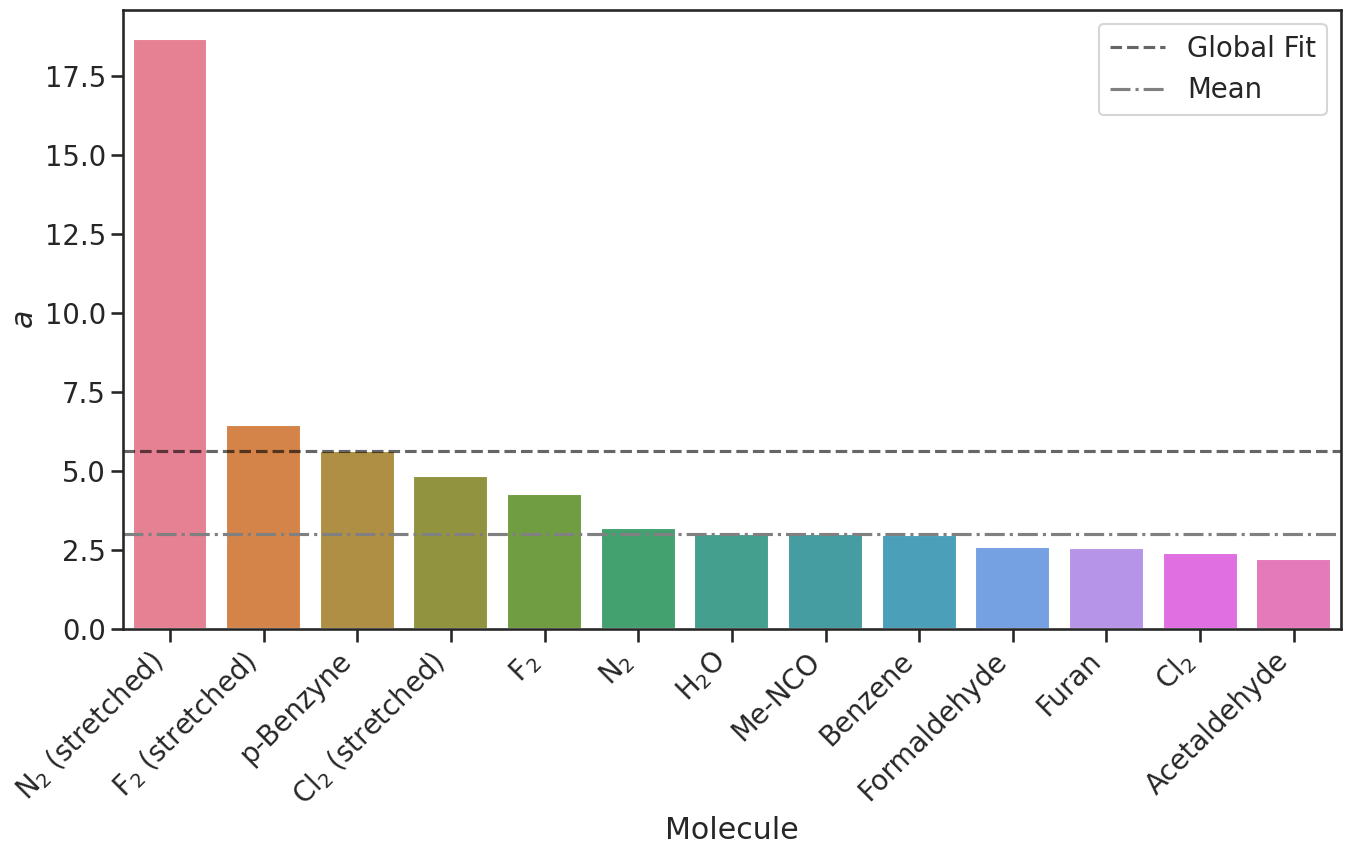

In [11]:
sns.set_theme(context="talk", font_scale=1.2, style="ticks")
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14, 9)
sns.barplot(data=df_per_mol_fits, x="molname", y="a", palette="husl", ax=ax)
# ax.get_xticks(rotation=90)
labels = ax.get_xticklabels()
nice_molnames = {
    "n2_stretched": r"N$_2$ (stretched)",
    "f2_stretched": r"F$_2$ (stretched)",
    "p-benzyne": r"p-Benzyne",
    "cl2_stretched": r"Cl$_2$ (stretched)",
    "f2": r"F$_2$",
    "n2": r"N$_2$",
    "h2o": r"H$_2$O",
    "nco": r"Me-NCO",
    "benzene": r"Benzene",
    "formaldehyde": r"Formaldehyde",
    "acetaldehyde": r"Acetaldehyde",
    "furan": r"Furan",
    "cl2": r"Cl$_2$",
}

labels = [nice_molnames[k.get_text()] for k in labels]

ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel(r"$a$")
ax.set_xlabel("Molecule")
# ax.axhline(
#     y=df_per_mol_fits['a'].median(), linestyle="--", color="gray", alpha=0.6, label="Median"
# )
print(a_fit)
ax.axhline(
    y=a_fit, linestyle="--", color="black", alpha=0.6, label="Global Fit"
)
ax.axhline(
    y=df_per_mol_fits['a'].median(), linestyle="-.", color="gray", alpha=1.0, label="Mean"
)
ax.legend()
plt.tight_layout()
plt.savefig("prefactor_per_molecule.png", dpi=300)
plt.savefig("prefactor_per_molecule.pdf", dpi=300)
df_per_mol_fits.to_hdf("per_molecule_prefactor_fits.h5", key="df")

In [45]:
def shot_budget(accuracy, nmo, nact, nalpha, nbeta, aexp, bexp, cexp):
    noverlaps = number_overlaps_tccsd(nact, nalpha, nbeta)
    assert nact == nalpha + nbeta
    bound = np.sqrt(2 * nact)  # sqrt(nqubits) -> sqrt(2*nact)
    nshots = aexp**2 / accuracy**2 * noverlaps**(2*bexp) * nmo**(2*cexp) * np.sqrt(2) * bound
    return nshots


def shot_budget_simple(accuracy, nmo, nact, aexp):
    """Relies on beta=0.25 and gamma=-1.0, with d being bound by nqubits^4, for half-filling bound = sqrt(nqubits)"""
    noverlaps = number_overlaps_tccsd(nact, nalpha, nbeta)
    bound = np.sqrt(2 * nact)  # sqrt(nqubits) -> sqrt(2*nact)
    # return np.sqrt(2) * bound * aexp**2 / accuracy**2 * noverlaps**0.5 / nmo**2
    return np.sqrt(2) * bound * aexp**2 / accuracy**2 * nact**2 / nmo**2

# nmos = np.arange(400, 1000 + 1, 200)
# nmos = [250, 400, 1000]
nmos = [600]
# nacts = list(range(4, 110, 10))
nacts = [
    4, 6, 8, 10,
    20, 30, 40, 50, 60, 80, 100
]
accuracy = 1e-3
budgets = []
for molname in prefactor_dict:
    for nmo in nmos:
        for nact in nacts:
            nalpha = nact // 2
            nbeta = nact // 2
            shots_global = shot_budget(accuracy, nmo, nact, nalpha, nbeta, prefactor_dict[molname], b_fit,             c_fit)
            shots_min =    shot_budget(accuracy, nmo, nact, nalpha, nbeta, prefactor_dict[molname], b_fit - stderr[1], c_fit - stderr[2])
            shots_max =    shot_budget(accuracy, nmo, nact, nalpha, nbeta, prefactor_dict[molname], b_fit + stderr[1], c_fit + stderr[2])
            # shots_simple = shot_budget_simple(accuracy, nmo, nact, prefactor_dict[molname])
            # print(shots_global, shots_simple)
            budgets.append([accuracy, nmo, nact, nalpha, nbeta, shots_global, shots_min, shots_max, molname])

df_shots = pd.DataFrame(data=budgets, columns=['accuracy', 'nmo', 'nact', 'nalpha', 'nbeta', 'shots_global', 'shots_min', 'shots_max', 'molname'])
df_shots['nqubits'] = 2 * df_shots.nact
display(df_shots)

,accuracy,nmo,nact,nalpha,nbeta,shots_global,shots_min,shots_max,molname,nqubits
0,0.001,600,4,2,2,9391.459004,1489.152419,5.922799e+04,n2_stretched,8
1,0.001,600,6,3,3,26069.251714,3522.253690,1.929463e+05,n2_stretched,12
2,0.001,600,8,4,4,55977.754550,6698.903491,4.677645e+05,n2_stretched,16
3,0.001,600,10,5,5,102343.663921,11124.137608,9.415764e+05,n2_stretched,20
4,0.001,600,20,10,10,680158.015738,54619.918622,8.469711e+06,n2_stretched,40
...,...,...,...,...,...,...,...,...,...,...
138,0.001,600,40,20,20,64007.260116,3795.514588,1.079413e+06,acetaldehyde,80
139,0.001,600,50,25,25,117765.843287,6334.918204,2.189262e+06,acetaldehyde,100
140,0.001,600,60,30,30,193739.584710,9624.798790,3.899825e+06,acetaldehyde,120
141,0.001,600,80,40,40,424725.575984,18613.013070,9.691704e+06,acetaldehyde,160


In [46]:
def low_bound(eta,k,n):
    import scipy
    var =  scipy.special.binom(eta,k)
    var *= (1-(eta-k)/n)**k
    var *= (1+n)/(1+n-k)
    return var


def shot_budget_low(accuracy, nmo, nact, nalpha, nbeta, aexp, bexp, cexp):
    noverlaps = number_overlaps_tccsd(nact, nalpha, nbeta)
    assert nact == nalpha + nbeta
    # bound = np.sqrt(2 * nact)  # sqrt(nqubits) -> sqrt(2*nact)

    zeta = nalpha + nbeta
    n = 2 * nact
    bound = low_bound(zeta, zeta, n + zeta)
    nshots = aexp**2 / accuracy**2 * noverlaps**(2*bexp) * nmo**(2*cexp) * bound
    return nshots


nmos = [600]
nacts = [
    4, 6, 8, 10,
    20, 30, 40, 50, 60, 80, 100
]
accuracy = 1e-3
budgets = []
for molname in prefactor_dict:
    for nmo in nmos:
        for nact in nacts:
            nalpha = nact // 2
            nbeta = nact // 2
            shots_global = shot_budget_low(accuracy, nmo, nact, nalpha, nbeta, prefactor_dict[molname], b_fit,             c_fit)
            shots_min =    shot_budget_low(accuracy, nmo, nact, nalpha, nbeta, prefactor_dict[molname], b_fit - stderr[1], c_fit - stderr[2])
            shots_max =    shot_budget_low(accuracy, nmo, nact, nalpha, nbeta, prefactor_dict[molname], b_fit + stderr[1], c_fit + stderr[2])
            # shots_simple = shot_budget_simple(accuracy, nmo, nact, prefactor_dict[molname])
            # print(shots_global, shots_simple)
            budgets.append([accuracy, nmo, nact, nalpha, nbeta, shots_global, shots_min, shots_max, molname])

df_shots_low = pd.DataFrame(data=budgets, columns=['accuracy', 'nmo', 'nact', 'nalpha', 'nbeta', 'shots_global', 'shots_min', 'shots_max', 'molname'])
df_shots_low['nqubits'] = 2 * df_shots_low.nact
display(df_shots_low)

,accuracy,nmo,nact,nalpha,nbeta,shots_global,shots_min,shots_max,molname,nqubits
0,0.001,600,4,2,2,3391.360196,537.749485,2.138788e+04,n2_stretched,8
1,0.001,600,6,3,3,7777.377749,1050.812573,5.756270e+04,n2_stretched,12
2,0.001,600,8,4,4,14552.297735,1741.485325,1.216027e+05,n2_stretched,16
3,0.001,600,10,5,5,23887.646534,2596.442779,2.197698e+05,n2_stretched,20
4,0.001,600,20,10,10,113138.601313,9085.566962,1.408866e+06,n2_stretched,40
...,...,...,...,...,...,...,...,...,...,...
138,0.001,600,40,20,20,7559.091413,448.240429,1.274759e+05,acetaldehyde,80
139,0.001,600,50,25,25,12449.729687,669.701987,2.314399e+05,acetaldehyde,100
140,0.001,600,60,30,30,18707.077617,929.349871,3.765587e+05,acetaldehyde,120
141,0.001,600,80,40,40,35540.586581,1557.517230,8.109915e+05,acetaldehyde,160


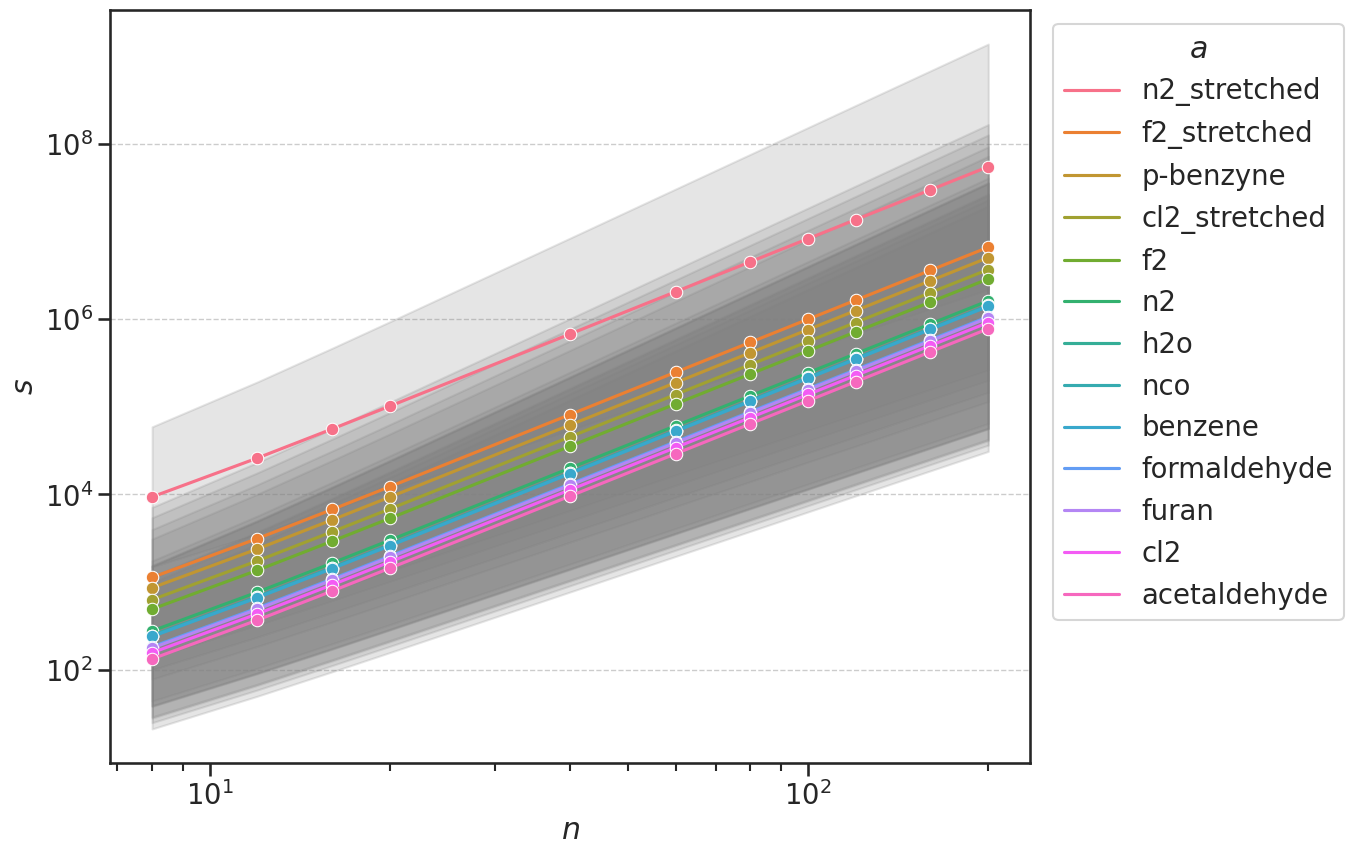

In [47]:
sns.set_theme(context="talk", font_scale=1.2, style="ticks")
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14, 9)

# sns.lineplot(data=df_shots, x="nqubits", y="shots_global", hue="molname", ax=ax, marker="o", palette="husl")
sns.lineplot(data=df_shots, x="nqubits", y="shots_global", hue="molname", ax=ax, marker="o", palette="husl")

molgroups = df_shots.groupby("molname")
for i, name in enumerate(prefactor_dict):
    group = molgroups.get_group(name)
    x = group["nqubits"]
    color = ax.get_lines()[i].get_c()
    
    lower = group["shots_min"]
    upper = group["shots_max"]
    color = 'gray'
    ax.fill_between(x, lower, upper, alpha=0.2, color=color)


ax.yaxis.grid(True, linestyle="--", linewidth=1, alpha=1)
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_ylabel(r"$s$")
ax.set_xlabel(r"$n$")
ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1.0), title=r"$a$")

# for tx in ax.get_legend().texts:
#     nice = nice_molnames[tx.get_text()]
#     tx.set_text(nice)
plt.tight_layout()

# plt.savefig("shotbudgets_all.pdf", dpi=300)
# plt.savefig("shotbudgets_all.png", dpi=300)


In [48]:
# df_shots['Shadow'] = "Matchgate"
# df_shots_low['Shadow'] = "Low"
# df_shots = pd.concat([df_shots, df_shots_low], axis=0)

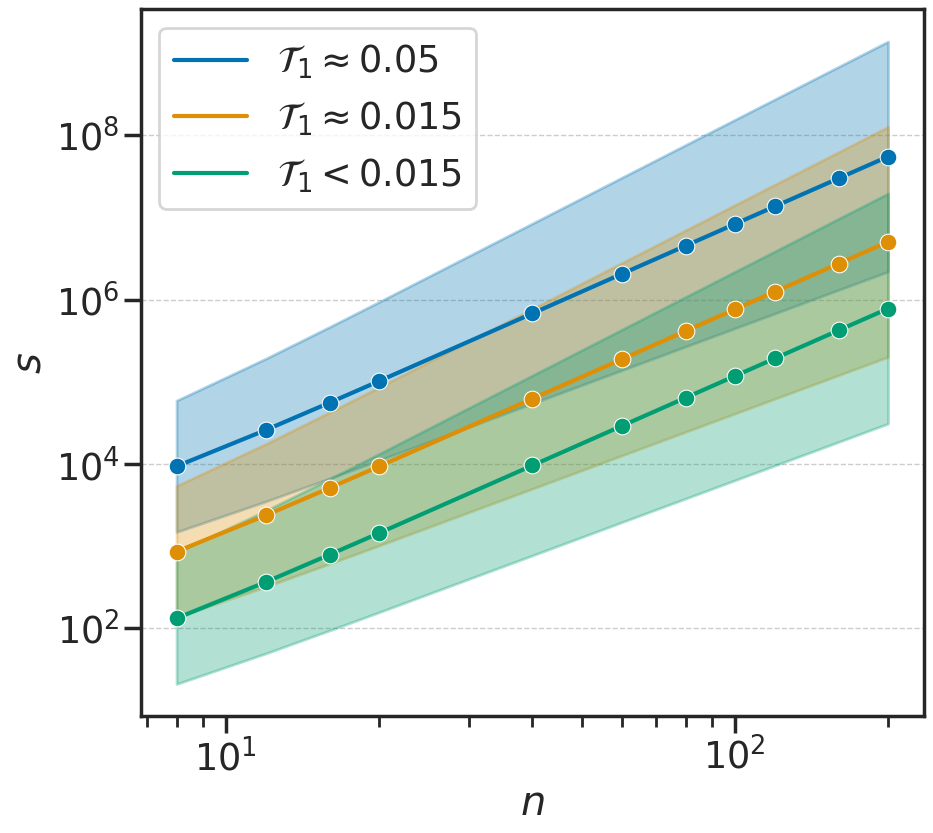

In [50]:
# plot for main text with strongly/weakly correlated extremes
# sns.set_theme(context="talk", font_scale=1.5, style="ticks")
sns.set_theme(context="poster", font_scale=1.2, style="ticks")
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 9)
# fig.set_size_inches(8, 6)

extremes = [
    'n2_stretched',
    # "f2_stretched",
    'p-benzyne',
    'acetaldehyde'
]
df_shots_extremes = df_shots[df_shots['molname'].isin(extremes)].copy()


scenarios = {
    # "n2_stretched": "Dominant static correlation",
    # "p-benzyne": "Mixed",
    # "acetaldehyde": "Dominant dynamic correlation"
    "n2_stretched": r"$\mathcal{T}_1 \approx 0.05$",
    # "f2_stretched": r"$\mathcal{T}_1 \approx 0.02$",
    "p-benzyne": r"$\mathcal{T}_1 \approx 0.015$",
    "acetaldehyde": r"$\mathcal{T}_1 < 0.015$",
}
df_shots_extremes['Scenario'] = df_shots_extremes['molname'].map(scenarios)
sns.lineplot(data=df_shots_extremes, x="nqubits", y="shots_global", hue="Scenario", ax=ax, marker="o", palette="colorblind")


molgroups = df_shots_extremes.groupby("molname")
for i, name in enumerate(extremes):
    group = molgroups.get_group(name)
    x = group["nqubits"]
    color = ax.get_lines()[i].get_c()
    
    lower = group["shots_min"]
    upper = group["shots_max"]
    # color = 'gray'
    ax.fill_between(x, lower, upper, alpha=0.3, color=color)


ax.yaxis.grid(True, linestyle="--", linewidth=1, alpha=1)
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_ylabel(r"$s$")
ax.set_xlabel(r"$n$")
ax.legend(
    # loc="upper left", bbox_to_anchor=(1.01, 1.0),
    # title="Scenario"
    title=None
)

# changes = {
#     "nmo": r"$N$",
#     "estimation": "",
#     "shots_global": "Power Law",
#     "shots_min": "Lower Bound",
#     "shots_max": "Upper Bound",
# }

# for tx in ax.get_legend().texts:
#     nice = scenarios[tx.get_text()]
#     tx.set_text(nice)

plt.tight_layout()

plt.savefig("shotbudgets_main.pdf", dpi=300)
plt.savefig("shotbudgets_main.png", dpi=300)

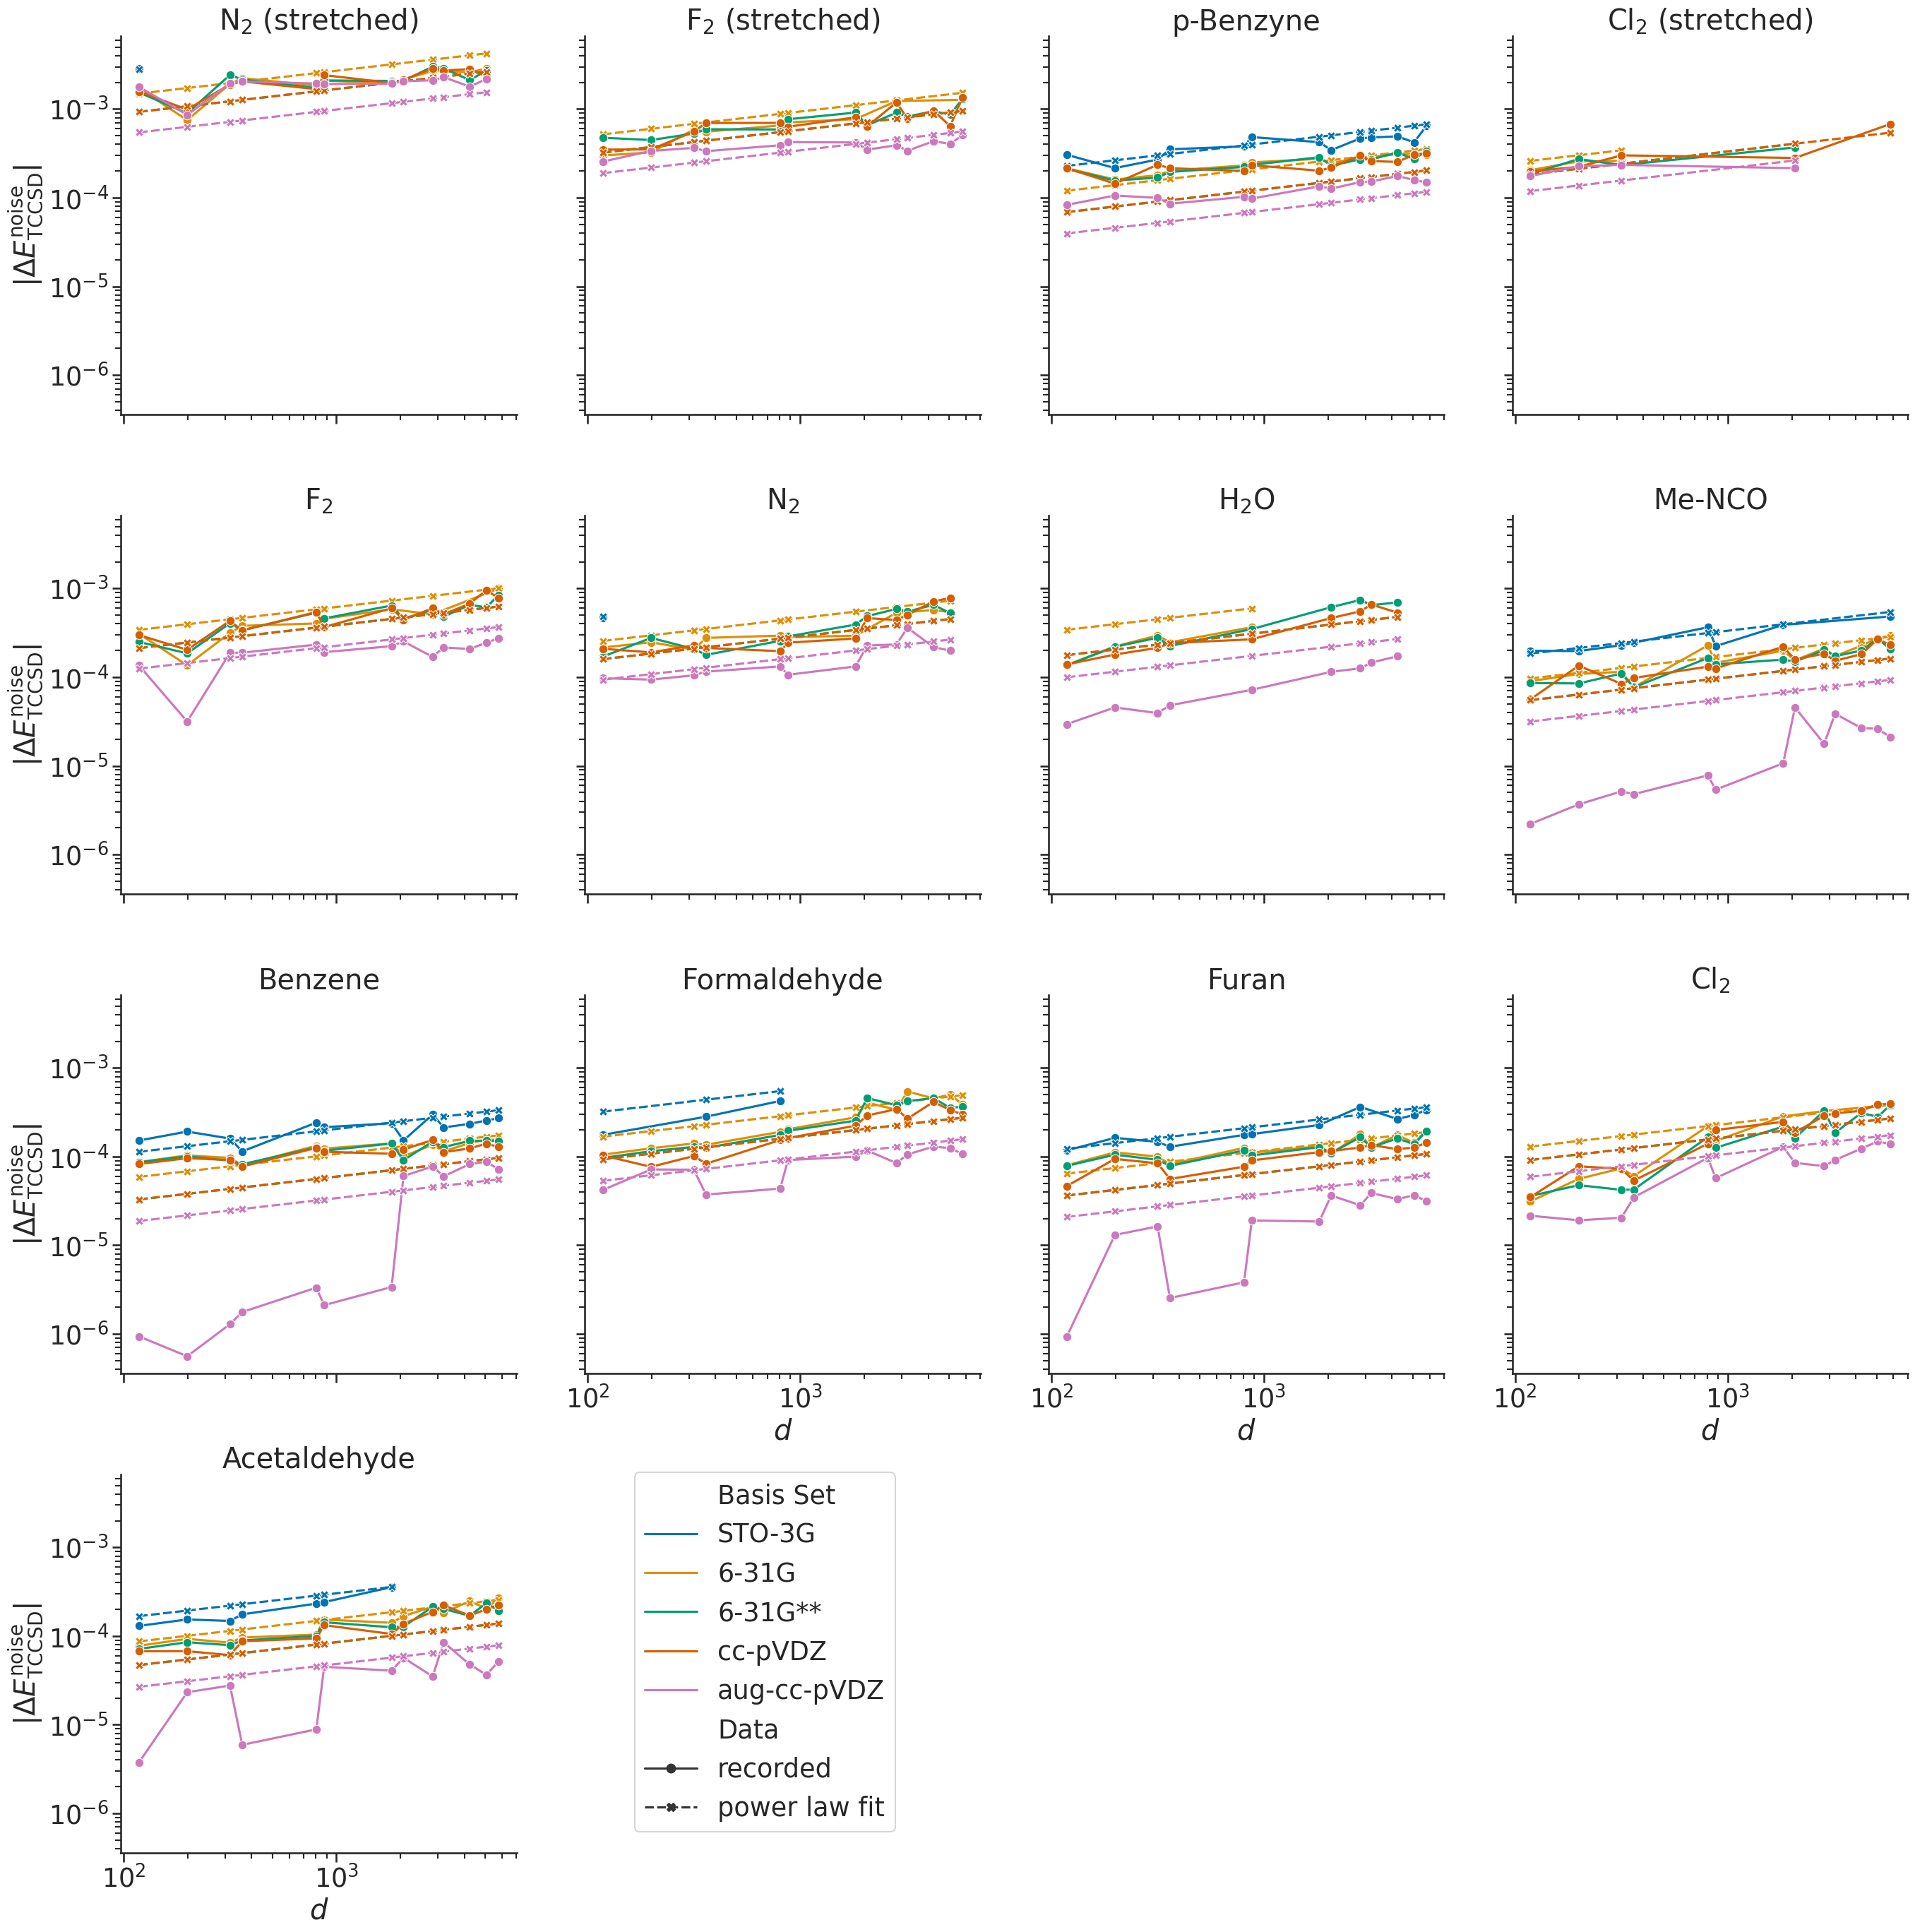

In [15]:
sns.set_theme(context="talk", font_scale=1.6, style="ticks")
dfm = pd.melt(merged_df, value_name="error", var_name="kind", id_vars=['std', 'noverlaps', 'molname', 'basis', 'nact', 'nalpha', 'nbeta', 'nelec', 'nmo'],
              value_vars=[
                  'tcc_error',
                  'tcc_error_fit',
                #   'tcc_error_fit_best', 'tcc_error_fit_worst'
                  ])

hue_order = [
    "sto-3g", "6-31g", "6-31g**", 'cc-pvdz', 'aug-cc-pvdz'
]
hue_nice = {
    'basis': "Basis Set",
    "sto-3g": "STO-3G",
    "6-31g": "6-31G",
    "6-31g**": "6-31G**",
    "cc-pvdz": "cc-pVDZ",
    "aug-cc-pvdz": "aug-cc-pVDZ",
    "kind": "Data",
    "tcc_error": "recorded",
    "tcc_error_fit": "power law fit"
}
# display(dfm)
g = sns.relplot(
    col_order=list(prefactor_dict.keys()),
    col_wrap=4,
    data=dfm,
    x="noverlaps",
    # x="nmo",
    y="error",
    col="molname",
    hue="basis",
    hue_order=hue_order,
    style="kind",
    markers=True,
    marker="o",
    # linewidth=2.5,
    # palette="flare",
    # errorbar=None,
    legend="full",
    height=7,
    kind="line",
    palette="colorblind",
)
g.set(
    xscale="log",
    yscale="log",
    ylabel=r"$|\Delta E_\mathrm{TCCSD}^\mathrm{noise}|$",
    xlabel=r"$d$",
)
for tx in g.legend.get_texts():
    key = tx.get_text()
    tx.set_text(hue_nice[key])
for ia, ax in enumerate(g.axes.flatten()):
    # ax.tick_params(labelbottom=True)
    ax.set_title(labels[ia])

sns.move_legend(g, "upper left", bbox_to_anchor=(.3, .25), frameon=True)

# plt.tight_layout()
plt.savefig("powerlaw_grid.png", dpi=300)
plt.savefig("powerlaw_grid.pdf", dpi=300)


In [16]:
grp = merged_df.groupby('noverlaps')
from pprint import pprint
blabla = {}
for ovlp, df_inner in grp:
    # print(ovlp, df_inner)
    if ovlp not in blabla:
        blabla[ovlp] = tuple(np.unique(x)[0] for x in (df_inner.nact, df_inner.nalpha, df_inner.nbeta))
pprint(blabla)

{118: (6, 3, 3),
 199: (8, 2, 2),
 316: (8, 3, 3),
 361: (8, 4, 4),
 805: (10, 6, 6),
 876: (10, 5, 5),
 1819: (12, 6, 6),
 2068: (16, 3, 3),
 2836: (14, 5, 5),
 3193: (16, 4, 4),
 4236: (16, 5, 5),
 5071: (16, 6, 6),
 5793: (16, 8, 8)}


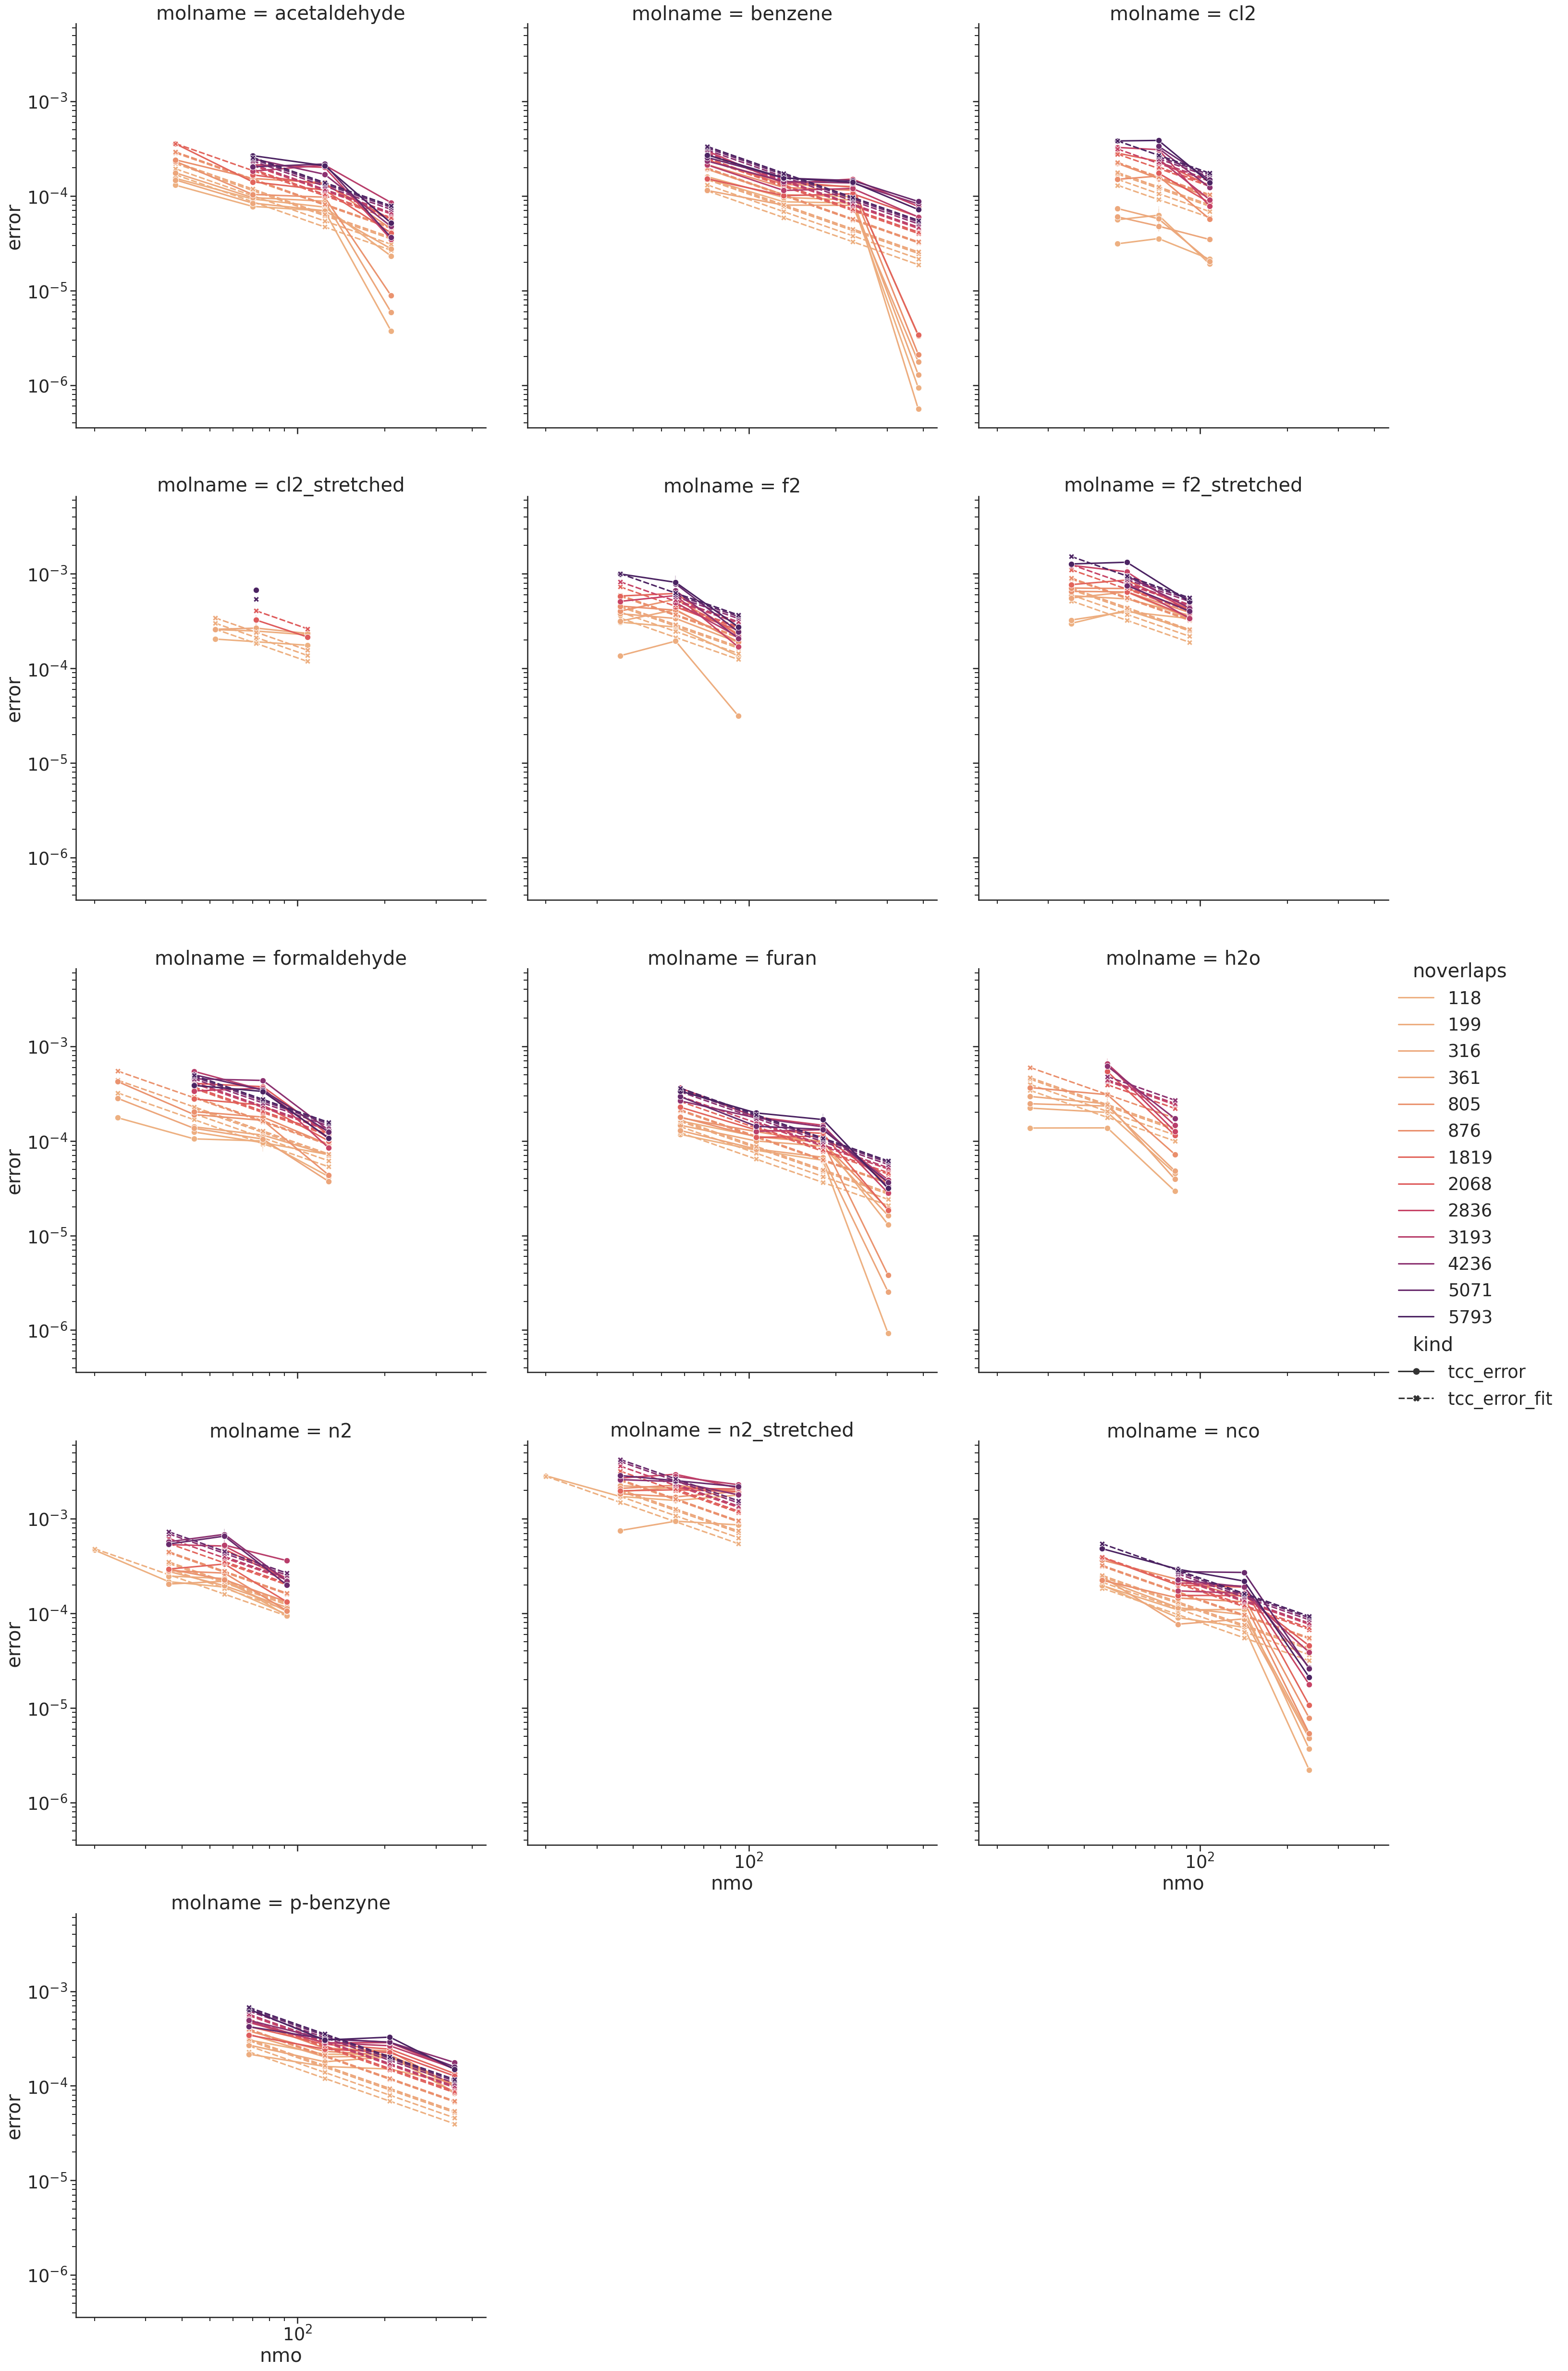

In [17]:
g = sns.relplot(
    # ax=ax,
    col_wrap=3,
    data=dfm,
    x="nmo",
    y="error",
    col="molname",
    hue="noverlaps",
    style="kind",
    markers=True,
    marker="o",
    # linewidth=2.5,
    palette="flare",
    # errorbar=None,
    legend="full",
    # legend="brief",
    # hue_norm=mpl.colors.LogNorm()
    height=10,
    kind="line",
)
g.set(
    xscale="log",
    yscale="log",
)

In [18]:
number_overlaps_tccsd(4, 2, 2)

27

In [19]:
from tailoredcc.amplitudes import number_nonredundant_amplitudes
number_nonredundant_amplitudes(4, 1, 1)

3

In [20]:
number_overlaps_tccsd(4, 2, 2)

27

In [21]:
n = 8
nocc = 4
nvirt = n - nocc

1 + nocc*nvirt + 1/4 * nocc**2 * nvirt **2

81.0